# Heart Disease Risk Prediction: Logistic Regression

## Step 1: Load and Prepare the Dataset

**Goal**: Load the Heart Disease dataset, clean it, and prepare it for training a logistic regression model.

**What we'll do**:
1. Load CSV into pandas DataFrame
2. Binarize target (Presence → 1, Absence → 0)
3. Exploratory Data Analysis (EDA)
4. Handle missing values/outliers
5. Select features
6. Split data (70/30 stratified)
7. Normalize features

In [2]:
# Standard imports for data science work
import numpy as np      # Numerical operations, arrays
import pandas as pd     # Data manipulation, DataFrames
import matplotlib.pyplot as plt  # Visualization

# Configure plots to look cleaner
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

## 1.1 Load the Dataset

**Why pandas?** It's the standard tool for tabular data. A DataFrame is like an Excel spreadsheet in Python - rows are samples, columns are features.


In [3]:
# Load the CSV file
# pd.read_csv() reads a CVS file and returns a DataFrame
df = pd.read_csv("dataset/Heart_Disease_Prediction.csv")

#Quick look at the data
print(f"Dataset shape: {df.shape}") # (rows, columns)
print(f"Samples: {df.shape[0]}, Features: {df.shape[1]}")
df.head() # Show first 5 rows

Dataset shape: (270, 14)
Samples: 270, Features: 14


,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence


In [4]:
# See all column names - important to know what you're working with
print("Columns in dataset:")
for i, col in enumerate(df.columns):
    print(f"  {i+1}. {col}")

Columns in dataset:
  1. Age
  2. Sex
  3. Chest pain type
  4. BP
  5. Cholesterol
  6. FBS over 120
  7. EKG results
  8. Max HR
  9. Exercise angina
  10. ST depression
  11. Slope of ST
  12. Number of vessels fluro
  13. Thallium
  14. Heart Disease


## 1.2 Binarize the Target Column

**Problem**: The target column "Heart Disease" has text values ("Presence", "Absence").  
**Solution**: Convert to numbers because ML models work with numbers.

| Original | Converted | Meaning |
|----------|-----------|--------|
| "Presence" | 1 | Has heart disease (positive class) |
| "Absence" | 0 | No heart disease (negative class) |

**Why 1 for disease?** Convention: 1 = "positive class" (what we're trying to detect).

In [5]:
# Check what values exist in the target column
print("Unique values in 'Heart Disease' column:")
print(df['Heart Disease'].value_counts())

# Map text to numbers: Presence → 1, Absence → 0
# .map() applies a dictionary transformation to each value
df['target'] = df['Heart Disease'].map({'Presence': 1, 'Absence': 0})

# Verify the conversion worked
print("\nAfter binarization:")
print(df['target'].value_counts())

Unique values in 'Heart Disease' column:
Heart Disease
Absence     150
Presence    120
Name: count, dtype: int64

After binarization:
target
0    150
1    120
Name: count, dtype: int64


### 1.3 Exploratory Data Analysis (EDA)

**Why EDA?** Before training any model, you MUST understand your data:
- What are the ranges of values?
- Are there missing values?
- Is the target balanced or imbalanced?
- Are there obvious patterns or outliers?

This step prevents garbage-in-garbage-out.

In [6]:
# Statistical summary of all numerical columns
# .describe() gives: count, mean, std, min, 25%, 50%, 75%, max
# This tells you the "shape" of your data
df.describe()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,target
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.00000,270.000000,270.000000,270.000000,270.000000
mean,54.433333,0.677778,3.174074,131.344444,249.659259,0.148148,1.022222,149.677778,0.329630,1.05000,1.585185,0.670370,4.696296,0.444444
std,9.109067,0.468195,0.950090,17.861608,51.686237,0.355906,0.997891,23.165717,0.470952,1.14521,0.614390,0.943896,1.940659,0.497827
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.00000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,213.000000,0.000000,0.000000,133.000000,0.000000,0.00000,1.000000,0.000000,3.000000,0.000000
50%,55.000000,1.000000,3.000000,130.000000,245.000000,0.000000,2.000000,153.500000,0.000000,0.80000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,280.000000,0.000000,2.000000,166.000000,1.000000,1.60000,2.000000,1.000000,7.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.20000,3.000000,3.000000,7.000000,1.000000


In [7]:
# Check for missing values - critical step!
# Missing values can break your model or bias results
print("Missing values per column:")
missing = df.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "No missing values found ✓")

# Also check data types - make sure numbers are numbers
print("\nData types:")
print(df.dtypes)

Missing values per column:
No missing values found ✓

Data types:
Age                          int64
Sex                          int64
Chest pain type              int64
BP                           int64
Cholesterol                  int64
FBS over 120                 int64
EKG results                  int64
Max HR                       int64
Exercise angina              int64
ST depression              float64
Slope of ST                  int64
Number of vessels fluro      int64
Thallium                     int64
Heart Disease                  str
target                       int64
dtype: object


Class Distribution:
  No disease (0): 150 samples (55.6%)
  Disease (1):    120 samples (44.4%)


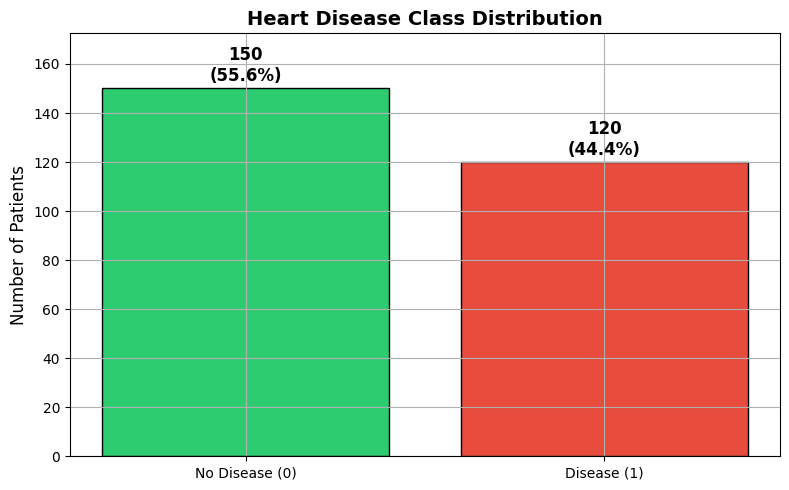


📊 Dataset is balanced (~44% disease rate)


In [8]:
# Class distribution - is the data balanced?
# Balanced: roughly 50/50. Imbalanced: one class dominates (e.g., 95/5)

disease_counts = df['target'].value_counts().sort_index()
disease_rate = df['target'].mean() * 100  # % of samples with disease

print("Class Distribution:")
print("=" * 40)
print(f"  No disease (0): {disease_counts[0]} samples ({100-disease_rate:.1f}%)")
print(f"  Disease (1):    {disease_counts[1]} samples ({disease_rate:.1f}%)")

# Visualize class distribution
fig, ax = plt.subplots(figsize=(8, 5))
colors = ['#2ecc71', '#e74c3c']  # Green for healthy, red for disease
bars = ax.bar(['No Disease (0)', 'Disease (1)'], disease_counts.values, color=colors, edgecolor='black')

# Add count and percentage labels on bars
for bar, count in zip(bars, disease_counts.values):
    percentage = count / len(df) * 100
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 3, 
            f'{count}\n({percentage:.1f}%)', ha='center', fontsize=12, fontweight='bold')

ax.set_ylabel('Number of Patients', fontsize=12)
ax.set_title('Heart Disease Class Distribution', fontsize=14, fontweight='bold')
ax.set_ylim(0, max(disease_counts.values) * 1.15)
plt.tight_layout()
plt.show()

print(f"\n📊 Dataset is {'balanced' if 40 < disease_rate < 60 else 'imbalanced'} (~{disease_rate:.0f}% disease rate)")

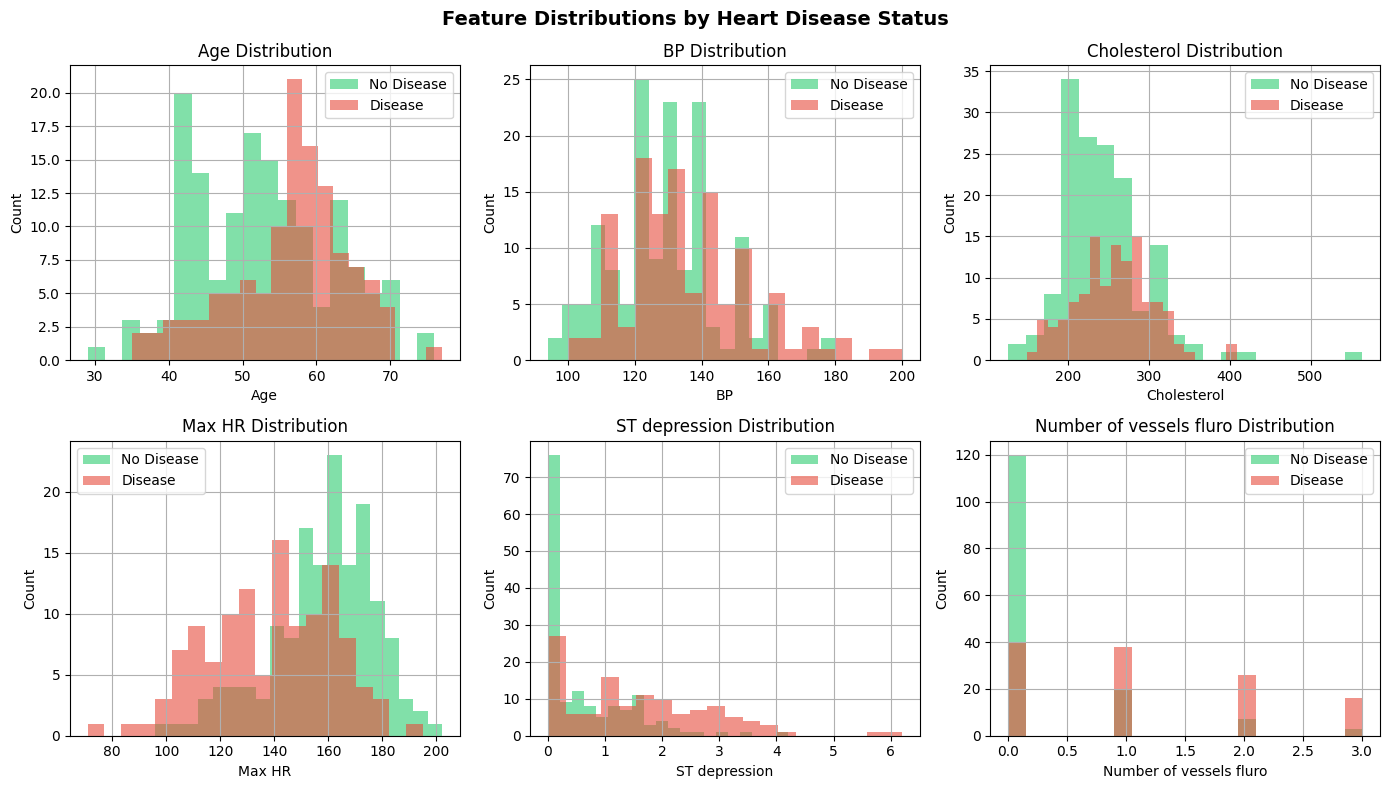

In [15]:
# Feature distributions - understand the range and spread of each feature
numerical_features = ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression', 'Number of vessels fluro']

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    ax = axes[i]
    # Histogram with different colors for each class
    ax.hist(df[df['target'] == 0][feature], bins=20, alpha=0.6, label='No Disease', color='#2ecc71')
    ax.hist(df[df['target'] == 1][feature], bins=20, alpha=0.6, label='Disease', color='#e74c3c')
    ax.set_xlabel(feature)
    ax.set_ylabel('Count')
    ax.set_title(f'{feature} Distribution')
    ax.legend()

plt.suptitle('Feature Distributions by Heart Disease Status', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 1.4 Feature Selection

**Why select features?** 
- Not all columns are equally useful for prediction
- Some features are categorical (need special handling)
- Start simple: pick numerical features that make medical sense

### Selected Features (6 as required):

| Feature | Medical Relevance |
|---------|------------------|
| `Age` | Older patients have higher cardiovascular risk |
| `BP` | High blood pressure is a major risk factor |
| `Cholesterol` | High cholesterol leads to arterial plaque |
| `Max HR` | Lower max heart rate may indicate heart problems |
| `ST depression` | ECG abnormality indicating potential ischemia |
| `Number of vessels fluro` | Vessels visible in fluoroscopy (blocked vessels) |

In [9]:
# Define which features to use
# List the exact column names from the dataset
feature_columns = [
    'Age',
    'BP',
    'Cholesterol',
    'Max HR',
    'ST depression',
    'Number of vessels fluro'
]

# Extract features (X) and target (y)
# X = feature matrix, shape (m, n) where m=samples, n=features
# y = target vector, shape (m,)
X = df[feature_columns].values  # .values converts DataFrame to NumPy array
y = df['target'].values

print(f"Features shape: {X.shape}")  # (samples, features)
print(f"Target shape: {y.shape}")    # (samples,)
print(f"\nFeatures selected: {feature_columns}")

Features shape: (270, 6)
Target shape: (270,)

Features selected: ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression', 'Number of vessels fluro']


### 1.5 Train/Test Split (70/30 Stratified)

**Why split?**  
- **Training set (70%)**: Model learns patterns from this data
- **Test set (30%)**: Evaluate model on data it has NEVER seen → measures real-world performance

**Why stratified?**  
Ensures both train and test have the same proportion of disease/no-disease.  
Without stratification, you might accidentally put all disease cases in training → test set has none → bad evaluation.

**Implementation**: Since we can't use scikit-learn, we'll do it manually:
1. Separate samples by class
2. Shuffle each class
3. Take 70% from each class for training

In [10]:
def stratified_train_test_split(X, y, train_ratio=0.7, random_seed=42):
    """
    Split data into train/test while maintaining class proportions.
    
    Parameters:
    - X: feature matrix (m, n)
    - y: target vector (m,)
    - train_ratio: fraction for training (0.7 = 70%)
    - random_seed: for reproducibility (same seed = same split every time)
    
    Returns:
    - X_train, X_test, y_train, y_test
    """
    np.random.seed(random_seed)  # Makes results reproducible
    
    # Get indices for each class
    idx_class_0 = np.where(y == 0)[0]  # Indices where y=0
    idx_class_1 = np.where(y == 1)[0]  # Indices where y=1
    
    # Shuffle indices (randomize order)
    np.random.shuffle(idx_class_0)
    np.random.shuffle(idx_class_1)
    
    # Calculate split points
    n_train_0 = int(len(idx_class_0) * train_ratio)
    n_train_1 = int(len(idx_class_1) * train_ratio)
    
    # Split each class
    train_idx_0 = idx_class_0[:n_train_0]
    test_idx_0 = idx_class_0[n_train_0:]
    
    train_idx_1 = idx_class_1[:n_train_1]
    test_idx_1 = idx_class_1[n_train_1:]
    
    # Combine indices
    train_idx = np.concatenate([train_idx_0, train_idx_1])
    test_idx = np.concatenate([test_idx_0, test_idx_1])
    
    # Shuffle combined indices (mix classes together)
    np.random.shuffle(train_idx)
    np.random.shuffle(test_idx)
    
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

In [11]:
# Perform the split
X_train, X_test, y_train, y_test = stratified_train_test_split(X, y, train_ratio=0.7)

# Verify the split
print("Split Results:")
print(f"  Training set: {X_train.shape[0]} samples")
print(f"  Test set:     {X_test.shape[0]} samples")

# Verify stratification (both should have similar disease rates)
train_disease_rate = y_train.mean() * 100
test_disease_rate = y_test.mean() * 100
print(f"\nDisease rate (should be similar):")
print(f"  Training: {train_disease_rate:.1f}%")
print(f"  Test:     {test_disease_rate:.1f}%")

Split Results:
  Training set: 189 samples
  Test set:     81 samples

Disease rate (should be similar):
  Training: 44.4%
  Test:     44.4%


In [12]:
# Compute normalization parameters from TRAINING data only
X_min = X_train.min(axis=0)  # Min of each column
X_max = X_train.max(axis=0)  # Max of each column

# Show original ranges
print("Original feature ranges (training data):")
for i, col in enumerate(feature_columns):
    print(f"  {col}: [{X_min[i]:.1f}, {X_max[i]:.1f}]")

Original feature ranges (training data):
  Age: [29.0, 71.0]
  BP: [94.0, 200.0]
  Cholesterol: [126.0, 564.0]
  Max HR: [95.0, 202.0]
  ST depression: [0.0, 6.2]
  Number of vessels fluro: [0.0, 3.0]


In [13]:
def normalize(X, X_min, X_max):
    """
    Apply min-max normalization.
    
    Formula: (x - min) / (max - min)
    Result: values in range [0, 1]
    """
    # Add small epsilon to avoid division by zero if max == min
    return (X - X_min) / (X_max - X_min + 1e-8)

# Normalize both train and test using TRAINING statistics
X_train_norm = normalize(X_train, X_min, X_max)
X_test_norm = normalize(X_test, X_min, X_max)

# Verify normalization worked
print("After normalization (training data):")
print(f"  Min values: {X_train_norm.min(axis=0)}")
print(f"  Max values: {X_train_norm.max(axis=0)}")
print("\nTest data may have slightly different range (that's OK):")
print(f"  Min values: {X_test_norm.min(axis=0).round(2)}")
print(f"  Max values: {X_test_norm.max(axis=0).round(2)}")

After normalization (training data):
  Min values: [0. 0. 0. 0. 0. 0.]
  Max values: [1. 1. 1. 1. 1. 1.]

Test data may have slightly different range (that's OK):
  Min values: [ 0.19  0.    0.03 -0.22  0.    0.  ]
  Max values: [1.14 0.92 0.64 0.93 0.9  1.  ]


### 1.7 Summary - Data Preparation Complete

What we did

In [14]:
# Final summary
print("=" * 60)
print("STEP 1 COMPLETE: Data Preparation Summary")
print("=" * 60)
print(f"""
Dataset: Heart Disease Prediction (Kaggle)
Source: https://www.kaggle.com/datasets/neurocipher/heartdisease

Samples: {len(df)} total
  - Training: {len(X_train)} ({len(X_train)/len(df)*100:.0f}%)
  - Test: {len(X_test)} ({len(X_test)/len(df)*100:.0f}%)

Target: Binary classification
  - 0 = No heart disease
  - 1 = Heart disease present
  - Disease rate: ~{y.mean()*100:.0f}%

Features selected ({len(feature_columns)}):
  {', '.join(feature_columns)}

Preprocessing:
  - Missing values: None
  - Normalization: Min-Max (values scaled to [0, 1])
  - Split: 70/30 stratified (class proportions preserved)

Ready for model training!
""")
print("=" * 60)

STEP 1 COMPLETE: Data Preparation Summary

Dataset: Heart Disease Prediction (Kaggle)
Source: https://www.kaggle.com/datasets/neurocipher/heartdisease

Samples: 270 total
  - Training: 189 (70%)
  - Test: 81 (30%)

Target: Binary classification
  - 0 = No heart disease
  - 1 = Heart disease present
  - Disease rate: ~44%

Features selected (6):
  Age, BP, Cholesterol, Max HR, ST depression, Number of vessels fluro

Preprocessing:
  - Missing values: None
  - Normalization: Min-Max (values scaled to [0, 1])
  - Split: 70/30 stratified (class proportions preserved)

Ready for model training!

